1) Se cargan las librerias necesarias

In [23]:
# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Selección y validación de modelos
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Técnicas de balanceo de clases
from imblearn.over_sampling import  SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


2) Se carga la base de datos

In [24]:
medical_appointments = pd.read_csv('Attendance of Medical Appointments in Brazil (may2016).csv')

3. Visualizacion de datos

In [25]:
# Numero de filas y columnas
medical_appointments.shape

(110527, 14)

In [26]:
# Encabezados
medical_appointments.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [27]:
# Tipo de datos
data_types = medical_appointments.dtypes
print(data_types)


PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


In [28]:
# Numero de valores unicos por columna
column_counts = medical_appointments.nunique()
print(column_counts)

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


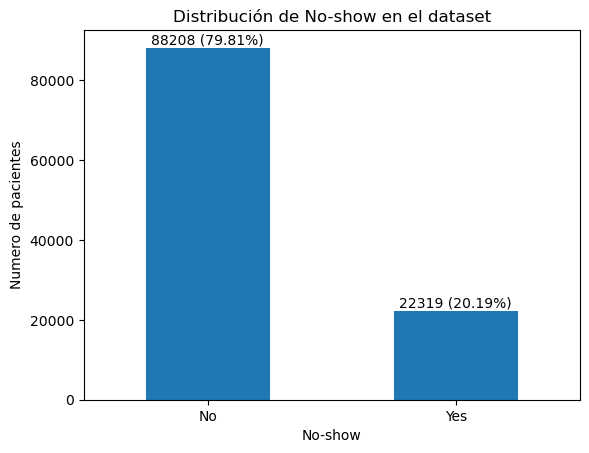

In [29]:
# Distribución del dataset
class_counts = medical_appointments['No-show'].value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(medical_appointments) * 100:.2f}%)', ha='center', va='bottom')
plt.show()

In [30]:
# Evaluar presencia de Missing values
missing_values = medical_appointments.isnull().sum()
print(missing_values)

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


4. Feature Engeniering

In [31]:
# Crear una copia del dataset original
medical_appointments_transformed = medical_appointments.copy()

# Transformar las fechas a formato datetime
medical_appointments_transformed['ScheduledDay'] = pd.to_datetime(medical_appointments_transformed['ScheduledDay'])
medical_appointments_transformed['AppointmentDay'] = pd.to_datetime(medical_appointments_transformed['AppointmentDay'])

# Se ordena el dataframe por el id del paciente y la fecha de la cita
medical_appointments_transformed.sort_values(by=['PatientId', 'ScheduledDay'], inplace=True)

# Se calcula el tiempo en segundos entre la fecha de la cita y la fecha de programación
medical_appointments_transformed['Time_Before_Appointment'] = (medical_appointments_transformed['AppointmentDay'] - medical_appointments_transformed['ScheduledDay']).dt.total_seconds()

# Se agrega el día de la semana de la cita
medical_appointments_transformed['Appointment_DayOfWeek'] = medical_appointments_transformed['AppointmentDay'].dt.day_name()


# Se calcula el tiempo en días desde la última cita de cada paciente
medical_appointments_transformed['Days Since Last Appointment'] = medical_appointments_transformed.groupby('PatientId')['ScheduledDay'].diff().dt.days

# Se asgina 0 a los pacientes que no tienen citas previas
medical_appointments_transformed['Days Since Last Appointment'].fillna(0, inplace=True)

# Se convierte de time a int
medical_appointments_transformed['ScheduledDay'] = medical_appointments_transformed['ScheduledDay'].dt.strftime('%Y%m%d').astype(int)
medical_appointments_transformed['AppointmentDay'] = medical_appointments_transformed['AppointmentDay'].dt.strftime('%Y%m%d').astype(int)

# Instanciar un nuevo LabelEncoder para cada columna categórica
gender_encoder = LabelEncoder()
neighbourhood_encoder = LabelEncoder()
no_show_encoder = LabelEncoder()
Appointment_DayOfWeek_encoder = LabelEncoder()

# Convertir las columnas categóricas a numéricas usando fit_transform
medical_appointments_transformed['Gender'] = gender_encoder.fit_transform(medical_appointments_transformed['Gender'])
medical_appointments_transformed['Neighbourhood'] = neighbourhood_encoder.fit_transform(medical_appointments_transformed['Neighbourhood'])
medical_appointments_transformed['No-show'] = no_show_encoder.fit_transform(medical_appointments_transformed['No-show'])
medical_appointments_transformed['Appointment_DayOfWeek'] = Appointment_DayOfWeek_encoder.fit_transform(medical_appointments_transformed['Appointment_DayOfWeek'])

# Visualizar los cambios
medical_appointments_transformed.head(10)



C:\Users\luiso\AppData\Local\Temp\ipykernel_27580\1796502347.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  medical_appointments_transformed['Days Since Last Appointment'].fillna(0, inplace=True)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Time_Before_Appointment,Appointment_DayOfWeek,Days Since Last Appointment
100517,3.921784e+04,5751990,0,20160531,20160603,44,56,0,0,0,0,0,0,0,219799.0,0,0.0
105430,4.374176e+04,5760144,1,20160601,20160601,39,43,0,0,1,0,0,0,0,-51778.0,5,0.0
3950,9.377953e+04,5712759,0,20160518,20160518,33,10,0,0,0,0,0,0,0,-33149.0,5,0.0
73303,1.417242e+05,5637648,1,20160429,20160502,12,23,0,0,0,0,0,0,0,233184.0,1,0.0
73228,5.376153e+05,5637728,0,20160429,20160506,14,23,0,0,0,0,0,1,0,578403.0,0,0.0
54611,5.628261e+06,5680449,1,20160510,20160513,13,52,0,0,0,0,0,0,1,216102.0,0,0.0
40692,1.183186e+07,5718578,1,20160519,20160519,16,69,0,0,0,0,0,0,0,-34927.0,3,0.0
58616,2.263866e+07,5580835,0,20160414,20160503,22,35,0,0,0,0,0,1,0,1614990.0,4,0.0
88585,2.263866e+07,5715081,0,20160518,20160608,23,35,0,0,0,0,0,1,0,1765368.0,5,34.0
49826,5.216894e+07,5607220,0,20160420,20160517,28,39,0,0,0,0,0,0,0,2291865.0,4,0.0


5. Se divide el dataset 

In [32]:
# Definir características (X) y etiqueta (y)
X = medical_appointments_transformed.drop('No-show', axis=1)  # Eliminar la columna 'No-show' para obtener las características
y = medical_appointments_transformed['No-show']  # La columna 'No-show' es nuestra etiqueta

# Dividir el dataset manteniendo la proporción de 'No-show' en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


4. Feature Engeniering 2: Se generan variables del dataset de entrenamiento

In [33]:
# Se une x_train y y_train para poder realizar el analisis
train_df = pd.concat([X_train, y_train], axis=1)

# Calcular la suma acumulativa de inasistencias ('No-show' == 1) por PatientId
train_df['Cumulative No-shows'] = train_df.groupby('PatientId')['No-show'].cumsum()

# Calcular el número acumulativo de citas por PatientId
train_df['Cumulative Appointments'] = train_df.groupby('PatientId').cumcount() + 1

# Calcular la probabilidad acumulativa de inasistencia por cita
train_df['Cumulative No-show Probability'] = train_df['Cumulative No-shows'] / train_df['Cumulative Appointments']

# Asignar un valor de 0 a la primera cita de cada paciente
train_df['Cumulative No-show Probability'] = train_df.groupby('PatientId')['Cumulative No-show Probability'].apply(lambda x: x.shift().fillna(0))

# Extraer el porcentaje acumulativo de inasistencia final por PatientId para agregarlo al DataFrame resumen
cumulative_no_show_percentage_final = train_df.groupby('PatientId')['Cumulative No-show Probability'].last()

# Convertir la serie a un DataFrame para un manejo más fácil
cumulative_no_show_percentage_df = cumulative_no_show_percentage_final.reset_index(name='Final Cumulative No-show Probability')

# Calcular el total de citas por PatientId para agregarlo al DataFrame resumen
total_appointments_by_patient = train_df.groupby('PatientId').size()

# Agregar el total de citas al DataFrame resumen
cumulative_no_show_percentage_df['Total Appointments'] = total_appointments_by_patient.values

# Visualizar los cambios
cumulative_no_show_percentage_df.head(10)


TypeError: incompatible index of inserted column with frame index

4.2 Se pasa la informacion al dataset de test

In [ ]:
# Unir el DataFrame de test con los porcentajes de 'No-show' basados en 'PatientId'
X_test = X_test.merge(cumulative_no_show_percentage_df, on='PatientId', how='left')

# Calcular el promedio de los porcentajes de 'No-show' del conjunto de entrenamiento
cumulative_no_show_percentage = cumulative_no_show_percentage_df['No-show Percentage'].mean()

# Se rellenan los valores nulos con el promedio
X_test['No-show Percentage'].fillna(cumulative_no_show_percentage, inplace=True)

# Se visualizan los cambios
X_test.head(10)


C:\Users\luiso\AppData\Local\Temp\ipykernel_24900\3698328952.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_with_no_show['No-show Percentage'].fillna(average_no_show_percentage, inplace=True)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Time_Before_Appointment,Appointment_DayOfWeek,No-show Percentage
0,9.135319e+13,5700655,1,20160516,20160516,7,9,0,0,0,0,0,0,-34752.0,1,19.674593
1,7.117627e+12,5666179,0,20160505,20160601,42,17,0,0,0,0,0,1,2274809.0,5,19.674593
2,3.948356e+12,5723058,1,20160520,20160603,3,78,1,0,0,0,0,1,1181077.0,0,0.000000
3,6.715146e+12,5634250,1,20160428,20160503,50,15,0,1,0,0,0,1,393750.0,4,0.000000
4,6.264199e+12,5696156,1,20160513,20160513,59,40,1,0,0,0,0,0,-42708.0,0,6.521739
5,2.765946e+12,5655794,1,20160504,20160504,0,69,0,0,0,0,0,0,-26000.0,5,0.000000
6,7.534428e+13,5647379,0,20160502,20160516,37,14,0,1,0,0,0,0,1160933.0,1,50.000000
7,3.674846e+13,5652636,0,20160503,20160503,71,1,0,1,1,0,0,0,-37487.0,4,19.674593
8,2.387212e+14,5668361,0,20160506,20160524,44,60,0,1,1,0,2,1,1523057.0,4,0.000000
9,1.214463e+12,5693686,0,20160513,20160517,60,12,0,1,1,0,0,0,318351.0,4,19.674593


4.3 Se elimina el 'PatientId' de los dataset

In [ ]:
# Se elimina la columna 'PatientId' del conjunto de entrenamiento y test
X_train = X_train.drop('PatientId', axis=1)
X_test = X_test.drop('PatientId', axis=1)

6.  Estandarización de datos

c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\seaborn\_oldcore.py:1119: F

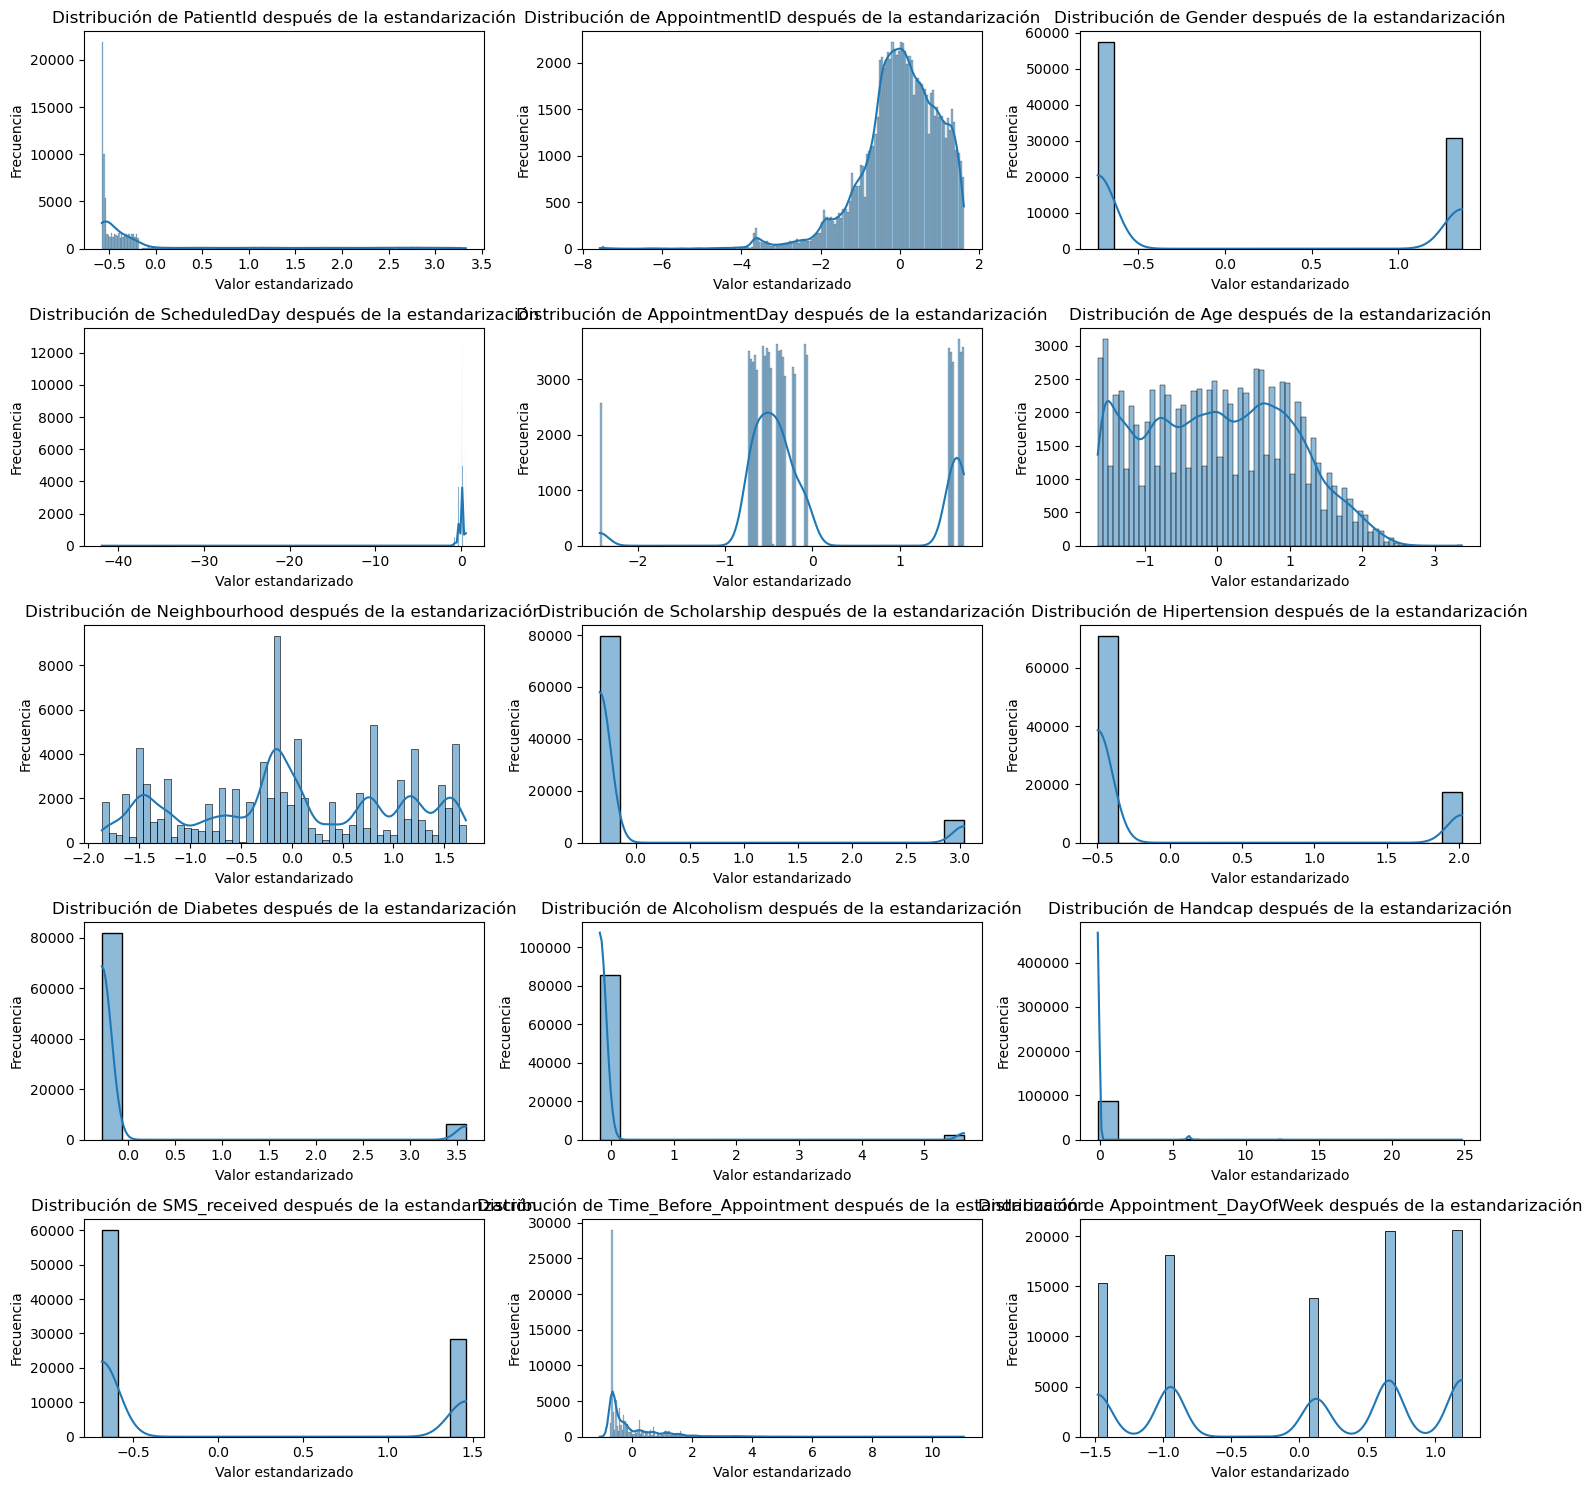

In [ ]:
# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos balanceados y se transforman
X_balanced_scaled = scaler.fit_transform(X_train)

# Convertir el resultado a DataFrame para facilitar la manipulación y visualización
X_balanced_scaled_df = pd.DataFrame(X_balanced_scaled, columns=X.columns)

# Número de características en el DataFrame
num_features = X_balanced_scaled_df.shape[1]

# Número de columnas para los subgráficos
num_columns = 3

# Número de filas calculadas en función del número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)

# Crear una figura grande para acomodar todos los subgráficos
plt.figure(figsize=(15, num_rows * 4))  

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    sns.histplot(X_balanced_scaled_df.iloc[:, i], kde=True)
    plt.title(f'Distribución de {X_balanced_scaled_df.columns[i]} después de la estandarización', fontsize=10)
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45) 

plt.subplots_adjust(hspace=0.5)  
plt.tight_layout()
plt.show()



7.Balanceo de clases

Text(0.5, 1.0, 'Distribución de No-show en el dataset')

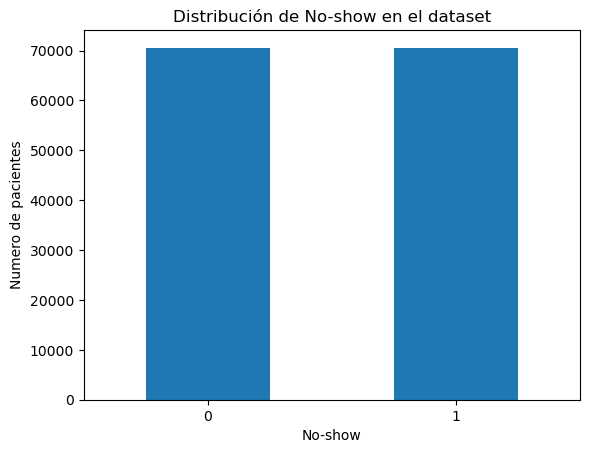

In [ ]:
# Se crea una instancia de SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Se aplica SMOTE a los datos
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Se aplica el pipeline a los datos
X_balanced, y_balanced = pipeline.fit_resample(X_train, y_train)

# Se grafica la distribución de las clases
class_counts = y_balanced.value_counts()
class_counts.plot(kind='bar', rot=0)
plt.xlabel('No-show')
plt.ylabel('Numero de pacientes')
plt.title('Distribución de No-show en el dataset')

8. Modelos de Machine Learning:

In [ ]:
# Definir las etiquetas para la matriz de confusión
labels = ['Asiste', 'No-show']

8.1 Entrenamiento Regresión Logisitica (datos balanceados y estandarizados)

In [ ]:
# Crear una instancia de LogisticRegression
clf_logistic = LogisticRegression()

# Diccionario de parametros a probar
param_grid = {
    'max_iter': [1000, 2000], # Numero de iteraciones
    'penalty': ['l2'], # Tipos de penalización
    'C': [0.01, 0.1, 1, 10, 100], # Valores de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # Algoritmos para la optimización
}

# Crear una instancia de GridSearchCV optimizada para la precisión
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

# Ajustar GridSearchCV
grid_search.fit(X_balanced, y_balanced)

# Ver los mejores parámetros y el mejor modelo
print('Mejores parámetros encontrados:', grid_search.best_params_)
print('Mejor modelo:', grid_search.best_estimator_)

# Se prueba el modelo en el conjunto de prueba (sin balancear)
y_pred_test_logistic = grid_search.best_estimator_.predict(X_test)

# Se crea una matriz de confusión utilizando el conjunto de prueba real y las predicciones
confusion_mat_test_logistic = confusion_matrix(y_test, y_pred_test_logistic)
sns.heatmap(confusion_mat_test_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión Regresión Logística (Mejores Parámetros)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Se calculan las métricas de evaluación utilizando el conjunto de prueba real
accuracy_test_logistic = accuracy_score(y_test, y_pred_test_logistic)
precision_test_logistic = precision_score(y_test, y_pred_test_logistic, pos_label=1)
recall_test_logistic = recall_score(y_test, y_pred_test_logistic, pos_label=1)

print("Accuracy (Conjunto de Prueba):", accuracy_test_logistic)
print("Precision (Conjunto de Prueba):", precision_test_logistic)
print("Recall (Conjunto de Prueba):", recall_test_logistic)
plt.show()



Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Mejores parámetros encontrados: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejor modelo: LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg')


c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\Users\luiso\anaconda3\envs\fraud-detection-environment\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


NameError: name 'labels' is not defined

8.2 Entrenamiento de DecisionTreeClassifier (Datos balanceados)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mejor puntaje de accuracy: 0.7186681987364272


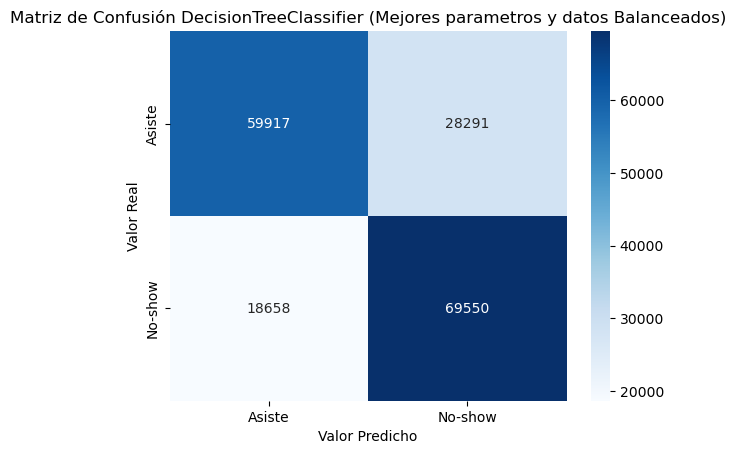

Accuracy (Datos Balanceados): 0.7338733448213314
Precision (Datos Balanceados): 0.7108471908504614
Recall (Datos Balanceados): 0.7884772356248866


In [ ]:
# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50], # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10], # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4], # Número mínimo de muestras requeridas en cada nodo hoja
    'criterion': ['gini', 'entropy'] # Función para medir la calidad de una división
}

# Crear una instancia de GridSearchCV, optimizada para la precisión
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ajustar GridSearchCV a los datos
grid_search.fit(X_balanced, y_balanced)

# Imprimir los mejores parámetros y el mejor puntaje
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntaje de accuracy:", grid_search.best_score_)

# Usar el mejor modelo para realizar predicciones
best_tree = grid_search.best_estimator_
y_pred_balanced = cross_val_predict(best_tree, X_balanced, y_balanced, cv=5)

# Crear y visualizar la matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión DecisionTreeClassifier (Mejores parametros y datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Calcular y mostrar las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced, pos_label=1)
recall_balanced = recall_score(y_balanced, y_pred_balanced, pos_label=1)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)

#Accuracy (Datos Balanceados): 0.7338733448213314
#Precision (Datos Balanceados): 0.7108471908504614
#Recall (Datos Balanceados): 0.7884772356248866


9. Modelos ensamblados

9.1 Entrneamiento de random forest Classifier

Accuracy (Datos Balanceados): 0.7516041628877199
Precision (Datos Balanceados): 0.7231152798303023
Recall (Datos Balanceados): 0.8154475784509342


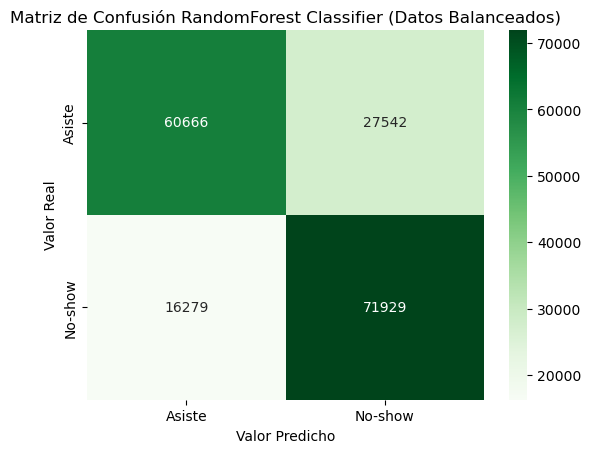

[[60666 27542]
 [16279 71929]]


In [ ]:
# Crear una instancia de RandomForestClassifier con parámetros predeterminados
rf_balanced = RandomForestClassifier(
    n_estimators=100,     # Numero de arboles
    max_depth=20,         # Profundidad del arbol, evita el sobreajuste
    min_samples_split=5,  # Aumentar este valor puede ayudar a evitar que el modelo se sobreajuste a los datos de entrenamiento.
    min_samples_leaf=2,   # Un valor más alto ayuda a suavizar el modelo, especialmente en problemas de clasificación.
    max_features='sqrt',  # Reducir el número de características consideradas para las divisiones puede hacer que el modelo sea más robusto.
    random_state=42,      # Fijar una semilla para reproducibilidad.
    class_weight='balanced'  # Clasees balanceadas
)

# Realizar la validación cruzada para obtener predicciones para todo el conjunto de datos
y_pred_balanced = cross_val_predict(rf_balanced, X_balanced, y_balanced, cv=5, method='predict')

# Se crea una matriz de confusión
confusion_mat_balanced = confusion_matrix(y_balanced, y_pred_balanced)
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_balanced, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

# Configuración del gráfico
plt.title('Matriz de Confusión RandomForest Classifier (Datos Balanceados)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')

# Se calculan las métricas de evaluación
accuracy_balanced = accuracy_score(y_balanced, y_pred_balanced)
precision_balanced = precision_score(y_balanced, y_pred_balanced)
recall_balanced = recall_score(y_balanced, y_pred_balanced)

print("Accuracy (Datos Balanceados):", accuracy_balanced)
print("Precision (Datos Balanceados):", precision_balanced)
print("Recall (Datos Balanceados):", recall_balanced)
plt.show()
print(confusion_mat_balanced)

9.2 Stacking: Regresión logistica + Decision Tree Classifier

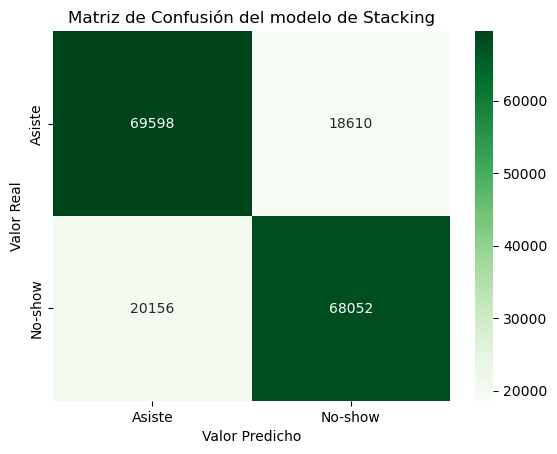

Accuracy del meta-modelo: 0.7802580264828587
Precision del meta-modelo: 0.7852576677205696
Recall del meta-modelo: 0.7714946490114275


In [ ]:
# Definir los modelos base con los parámetros optimizados
clf_tree_balanced = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=4
)
clf_logistic = LogisticRegression(
    max_iter=1000,
    penalty='l2', 
    C=1,  
    solver='lbfgs' 
)

# Configurar el k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Se preparan las matrices para almacenar las predicciones de los modelos base
y_pred_tree = np.zeros((X_balanced_scaled.shape[0], 2))  
y_pred_logistic = np.zeros((X_balanced_scaled.shape[0], 2))  

# Generar predicciones de validación cruzada para los modelos base
for train_index, test_index in kf.split(X_balanced_scaled):
    X_train_kf, X_test_kf = X_balanced_scaled[train_index], X_balanced_scaled[test_index]
    y_train_kf, y_test_kf = y_balanced[train_index], y_balanced[test_index]

    # Entrenar los modelos base en el fold actual
    clf_tree_balanced.fit(X_train_kf, y_train_kf)
    clf_logistic.fit(X_train_kf, y_train_kf)

    # Almacenar las predicciones en las matrices
    y_pred_tree[test_index] = clf_tree_balanced.predict_proba(X_test_kf)
    y_pred_logistic[test_index] = clf_logistic.predict_proba(X_test_kf)

# Usar las predicciones como características para el meta-modelo
X_meta_train = np.hstack((y_pred_tree, y_pred_logistic))

# Crear y entrenar el meta-modelo
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_balanced)

# Obtener las etiquetas de clase predichas para la matriz de confusión y las métricas
y_pred_meta = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict')

# Crear la matriz de confusión y calcular las métricas
confusion_mat_meta = confusion_matrix(y_balanced, y_pred_meta)
accuracy_meta = accuracy_score(y_balanced, y_pred_meta)
precision_meta = precision_score(y_balanced, y_pred_meta, pos_label=1)
recall_meta = recall_score(y_balanced, y_pred_meta, pos_label=1)

# Visualizar la matriz de confusión
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_meta, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión del modelo de Stacking')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Imprimir las métricas de evaluación
print("Accuracy del meta-modelo:", accuracy_meta)
print("Precision del meta-modelo:", precision_meta)
print("Recall del meta-modelo:", recall_meta)


10. Feature Selection

In [ ]:
# Eliminar las columnas 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'
# Datos que no se obtienen en el momento de la cita
X_balanced_scaled_drop = X_balanced_scaled_df.drop(['Hipertension', 'Diabetes', 'Alcoholism', 'Handcap','Scholarship'], axis=1)

# Se eliminan datos no relevantes
X_balanced_scaled_drop = X_balanced_scaled_drop.drop(['AppointmentID'], axis=1)

# Mostrar los primeros encabezados del nuevo conjunto de datos
X_balanced_scaled_drop.head()


,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,SMS_received,Time_Before_Appointment,Appointment_DayOfWeek
0,-0.458827,-0.615318,-0.2248,-2.594489,1.213158,-0.117510,-0.6153,-0.838697,-1.474598
1,1.611672,1.625176,-0.2248,-2.594489,0.934423,-0.117510,-0.6153,-0.831748,-1.474598
2,-0.559039,-0.615318,-0.2248,-2.594489,1.213158,0.166318,-0.6153,-0.832241,-1.474598
3,-0.572324,-0.615318,-0.2248,-2.594489,-1.295458,0.592059,-0.6153,-0.835512,-1.474598
4,-0.541124,-0.615318,-0.2248,-2.594489,0.934423,-0.117510,-0.6153,-0.831699,-1.474598


11. Se entrena nuevamente el modelo ensamblado pero con datos no clinicos

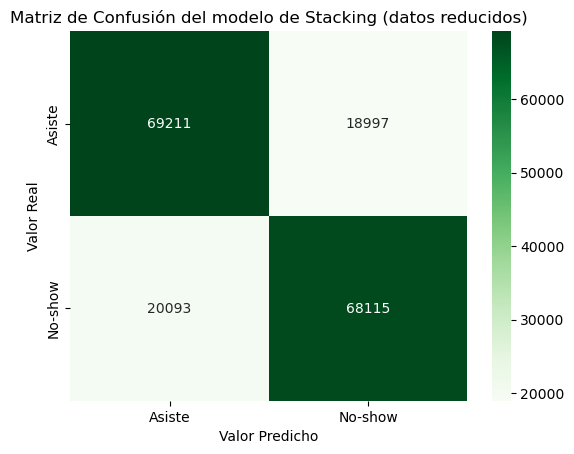

Accuracy del meta-modelo: 0.7784214583711228
Precision del meta-modelo: 0.7819244191385802
Recall del meta-modelo: 0.7722088699437692


In [ ]:
# Definir los modelos base con los parámetros optimizados
clf_tree_balanced = DecisionTreeClassifier(
    criterion='entropy',  
    max_depth=10,  
    min_samples_split=2,
    min_samples_leaf=4
)
clf_logistic = LogisticRegression(
    max_iter=1000,
    penalty='l2', 
    C=1,  
    solver='lbfgs' 
)

# Configurar el k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Se preparan las matrices para almacenar las predicciones de los modelos base
y_pred_tree = np.zeros((X_balanced_scaled_drop.shape[0], 2))  
y_pred_logistic = np.zeros((X_balanced_scaled_drop.shape[0], 2))  

# Generar predicciones de validación cruzada para los modelos base
for train_index, test_index in kf.split(X_balanced_scaled_drop):
    X_train_kf, X_test_kf = X_balanced_scaled_drop.iloc[train_index], X_balanced_scaled_drop.iloc[test_index]
    y_train_kf, y_test_kf = y_balanced[train_index], y_balanced[test_index]

    # Entrenar los modelos base en el fold actual
    clf_tree_balanced.fit(X_train_kf, y_train_kf)
    clf_logistic.fit(X_train_kf, y_train_kf)

    # Almacenar las predicciones en las matrices
    y_pred_tree[test_index] = clf_tree_balanced.predict_proba(X_test_kf)
    y_pred_logistic[test_index] = clf_logistic.predict_proba(X_test_kf)

# Usar las predicciones como características para el meta-modelo
X_meta_train = np.hstack((y_pred_tree, y_pred_logistic))

# Crear y entrenar el meta-modelo
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_balanced)

# Obtener las etiquetas de clase predichas para la matriz de confusión y las métricas
y_pred_meta = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict')

# Generar predicciones de probabilidad con el meta-modelo para evaluar
y_predict_proba = cross_val_predict(meta_model, X_meta_train, y_balanced, cv=5, method='predict_proba')

# Crear la matriz de confusión y calcular las métricas
confusion_mat_meta = confusion_matrix(y_balanced, y_pred_meta)
accuracy_meta = accuracy_score(y_balanced, y_pred_meta)
precision_meta = precision_score(y_balanced, y_pred_meta, pos_label=1)
recall_meta = recall_score(y_balanced, y_pred_meta, pos_label=1)

# Visualizar la matriz de confusión
labels = ['Asiste', 'No-show']
sns.heatmap(confusion_mat_meta, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión del modelo de Stacking (datos reducidos)')
plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.show()

# Imprimir las métricas de evaluación
print("Accuracy del meta-modelo:", accuracy_meta)
print("Precision del meta-modelo:", precision_meta)
print("Recall del meta-modelo:", recall_meta)


12. Se genera listado de probabilidad por usuario

In [ ]:
# Seleccionar la columna de la probabilidad de interés (segunda columna para la clase positiva)
probabilidad_inasistencia = y_predict_proba[:, 1] 

# Crear el DataFrame usando la probabilidad seleccionada y el Patient ID
usuarios_prob_df = pd.DataFrame({
    'PatientId': X_balanced['PatientId'],
    'Probabilidad_Inasistencia': probabilidad_inasistencia
})

# Exportar a un archivo CSV
usuarios_prob_df.to_csv('listado_probabilidad_inasistencia.csv', index=False)
listado_probabilidad_inasistencia = pd.read_csv('listado_probabilidad_inasistencia.csv')
print(listado_probabilidad_inasistencia.head())

      PatientId  Probabilidad_Inasistencia
0  2.987250e+13                   0.100172
1  5.589978e+14                   0.108941
2  4.262962e+12                   0.093255
3  8.679512e+11                   0.204041
4  8.841186e+12                   0.081749
